In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\slm\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back])
    return np.array(dataX), np.array(dataY)

def create_timeframe(X, y, t, k):
    time_data = X[t - k: t]
    time_targ = y[t - k: t]
    vali_data = X[t + 1: train_split]
    vali_targ = y[t + 1: train_split]
    return time_data, time_targ, vali_data, vali_targ

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [3]:
df = pd.read_csv("../data/daily-min-temperatures.csv")

In [4]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

learning_rate = 0.001
epochs = 10
t, k = 2200, 1200
# reshape into X=t and Y=t+1
look_back = 1
#Create dataset creates targets as next entries value
train, test = df["Temp"].iloc[0:train_split], df["Temp"].iloc[train_split:]
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
#LSTM only accepts 3D inputs, increase dimensionality
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)

In [5]:
# create and fit LSTM model
model = Sequential()
model.add(keras.layers.LSTM(32))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [6]:
h = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback, modelckpt_callback])


Train on 1200 samples, validate on 717 samples
Epoch 1/200
 - 2s - loss: 41.1045 - val_loss: 9.4571

Epoch 00001: val_loss improved from inf to 9.45707, saving model to model_checkpoint.h5
Epoch 2/200
 - 1s - loss: 8.1898 - val_loss: 7.6917

Epoch 00002: val_loss improved from 9.45707 to 7.69168, saving model to model_checkpoint.h5
Epoch 3/200
 - 1s - loss: 7.2294 - val_loss: 7.1541

Epoch 00003: val_loss improved from 7.69168 to 7.15414, saving model to model_checkpoint.h5
Epoch 4/200
 - 1s - loss: 7.0224 - val_loss: 6.9549

Epoch 00004: val_loss improved from 7.15414 to 6.95494, saving model to model_checkpoint.h5
Epoch 5/200
 - 1s - loss: 6.9823 - val_loss: 6.9079

Epoch 00005: val_loss improved from 6.95494 to 6.90795, saving model to model_checkpoint.h5
Epoch 6/200
 - 1s - loss: 6.9243 - val_loss: 6.7985

Epoch 00006: val_loss improved from 6.90795 to 6.79854, saving model to model_checkpoint.h5
Epoch 7/200
 - 1s - loss: 6.8539 - val_loss: 6.7718

Epoch 00007: val_loss improved f

In [7]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Estimate model performance
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 6.72 MSE (2.59 RMSE)
Test Score: 5.95 MSE (2.44 RMSE)


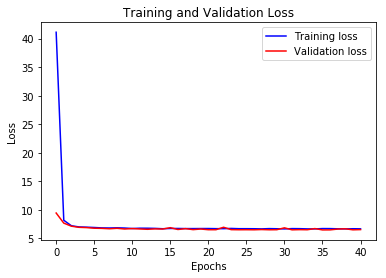

In [9]:
visualize_loss(h, "Training and Validation Loss")

Train on 500 samples, validate on 1717 samples
Epoch 1/200
 - 1s - loss: 6.7349 - val_loss: 6.7824

Epoch 00001: val_loss did not improve from 6.50078
Epoch 2/200
 - 1s - loss: 6.7555 - val_loss: 6.6410

Epoch 00002: val_loss did not improve from 6.50078
Epoch 3/200
 - 1s - loss: 6.6562 - val_loss: 6.8246

Epoch 00003: val_loss did not improve from 6.50078
Epoch 4/200
 - 1s - loss: 6.6500 - val_loss: 6.6332

Epoch 00004: val_loss did not improve from 6.50078
Epoch 5/200
 - 1s - loss: 6.7035 - val_loss: 6.7858

Epoch 00005: val_loss did not improve from 6.50078
Epoch 6/200
 - 1s - loss: 6.7009 - val_loss: 6.6686

Epoch 00006: val_loss did not improve from 6.50078
Epoch 7/200
 - 1s - loss: 6.6732 - val_loss: 6.7347

Epoch 00007: val_loss did not improve from 6.50078
Epoch 8/200
 - 1s - loss: 6.6891 - val_loss: 6.7652

Epoch 00008: val_loss did not improve from 6.50078
Epoch 9/200
 - 1s - loss: 6.6362 - val_loss: 6.6109

Epoch 00009: val_loss did not improve from 6.50078
Epoch 10/200
 - 1

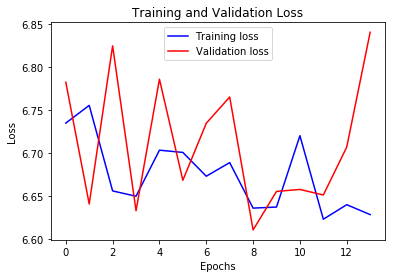

In [14]:
t, k = 1200, 500
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)
h2 = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback, modelckpt_callback])
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
visualize_loss(h2, "Training and Validation Loss")

Train on 1000 samples, validate on 1417 samples
Epoch 1/200
 - 1s - loss: 7.2220 - val_loss: 6.4978

Epoch 00001: val_loss improved from 6.50078 to 6.49779, saving model to model_checkpoint.h5
Epoch 2/200
 - 1s - loss: 7.2352 - val_loss: 6.5314

Epoch 00002: val_loss did not improve from 6.49779
Epoch 3/200
 - 1s - loss: 7.2290 - val_loss: 6.5737

Epoch 00003: val_loss did not improve from 6.49779
Epoch 4/200
 - 1s - loss: 7.2593 - val_loss: 6.7035

Epoch 00004: val_loss did not improve from 6.49779
Epoch 5/200
 - 1s - loss: 7.2641 - val_loss: 6.5597

Epoch 00005: val_loss did not improve from 6.49779
Epoch 6/200
 - 1s - loss: 7.2265 - val_loss: 6.4919

Epoch 00006: val_loss improved from 6.49779 to 6.49186, saving model to model_checkpoint.h5
Epoch 7/200
 - 1s - loss: 7.2228 - val_loss: 6.6354

Epoch 00007: val_loss did not improve from 6.49186
Epoch 8/200
 - 1s - loss: 7.2014 - val_loss: 6.7987

Epoch 00008: val_loss did not improve from 6.49186
Epoch 9/200
 - 1s - loss: 7.2492 - val

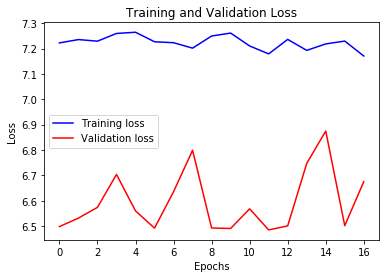

In [15]:
t, k = 1500, 1000
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)
h3 = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback, modelckpt_callback])
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
visualize_loss(h3, "Training and Validation Loss")

Train on 2000 samples, validate on 517 samples
Epoch 1/200
 - 1s - loss: 6.9547 - val_loss: 6.7752

Epoch 00001: val_loss did not improve from 6.48479
Epoch 2/200
 - 1s - loss: 6.9571 - val_loss: 6.7342

Epoch 00002: val_loss did not improve from 6.48479
Epoch 3/200
 - 1s - loss: 6.9474 - val_loss: 6.7981

Epoch 00003: val_loss did not improve from 6.48479
Epoch 4/200
 - 1s - loss: 6.9762 - val_loss: 6.9241

Epoch 00004: val_loss did not improve from 6.48479
Epoch 5/200
 - 1s - loss: 6.9628 - val_loss: 6.7352

Epoch 00005: val_loss did not improve from 6.48479
Epoch 6/200
 - 1s - loss: 6.9425 - val_loss: 6.7219

Epoch 00006: val_loss did not improve from 6.48479
Epoch 7/200
 - 1s - loss: 6.9613 - val_loss: 6.8364

Epoch 00007: val_loss did not improve from 6.48479
Epoch 8/200
 - 1s - loss: 6.9692 - val_loss: 6.7316

Epoch 00008: val_loss did not improve from 6.48479
Epoch 9/200
 - 1s - loss: 6.9678 - val_loss: 6.8726

Epoch 00009: val_loss did not improve from 6.48479
Epoch 10/200
 - 1

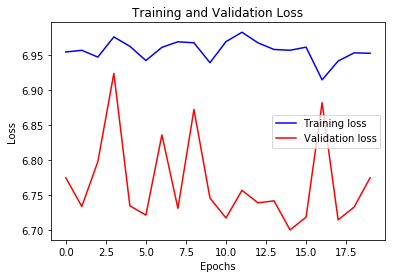

In [16]:
t, k = 2400, 2000
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
#Create the timeframe w.r.t t and k values
X_train, y_train, X_val, y_val = create_timeframe(X_train, y_train, t, k)
h2 = model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2, validation_data=(X_val, y_val), callbacks=[es_callback, modelckpt_callback])
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
visualize_loss(h2, "Training and Validation Loss")